## Release the Kraken!

In [3]:
import kraken

In [4]:
from kraken import pageseg
help(pageseg)

Help on module kraken.pageseg in kraken:

NAME
    kraken.pageseg

DESCRIPTION
    kraken.pageseg
    ~~~~~~~~~~~~~~
    
    Layout analysis and script detection methods.

FUNCTIONS
    detect_scripts(im, bounds, model='/home/rktirtho/anaconda3/lib/python3.8/site-packages/kraken/script.mlmodel', valid_scripts=None)
        Detects scripts in a segmented page.
        
        Classifies lines returned by the page segmenter into runs of scripts/writing systems.
        
        Args:
            im (PIL.Image): A bi-level page of mode '1' or 'L'
            bounds (dict): A dictionary containing a 'boxes' entry with a list of
                           coordinates (x0, y0, x1, y1) of a text line in the image
                           and an entry 'text_direction' containing
                           'horizontal-lr/rl/vertical-lr/rl'.
            model (str): Location of the script classification model or None for default.
            valid_scripts (list): List of valid scripts.
     

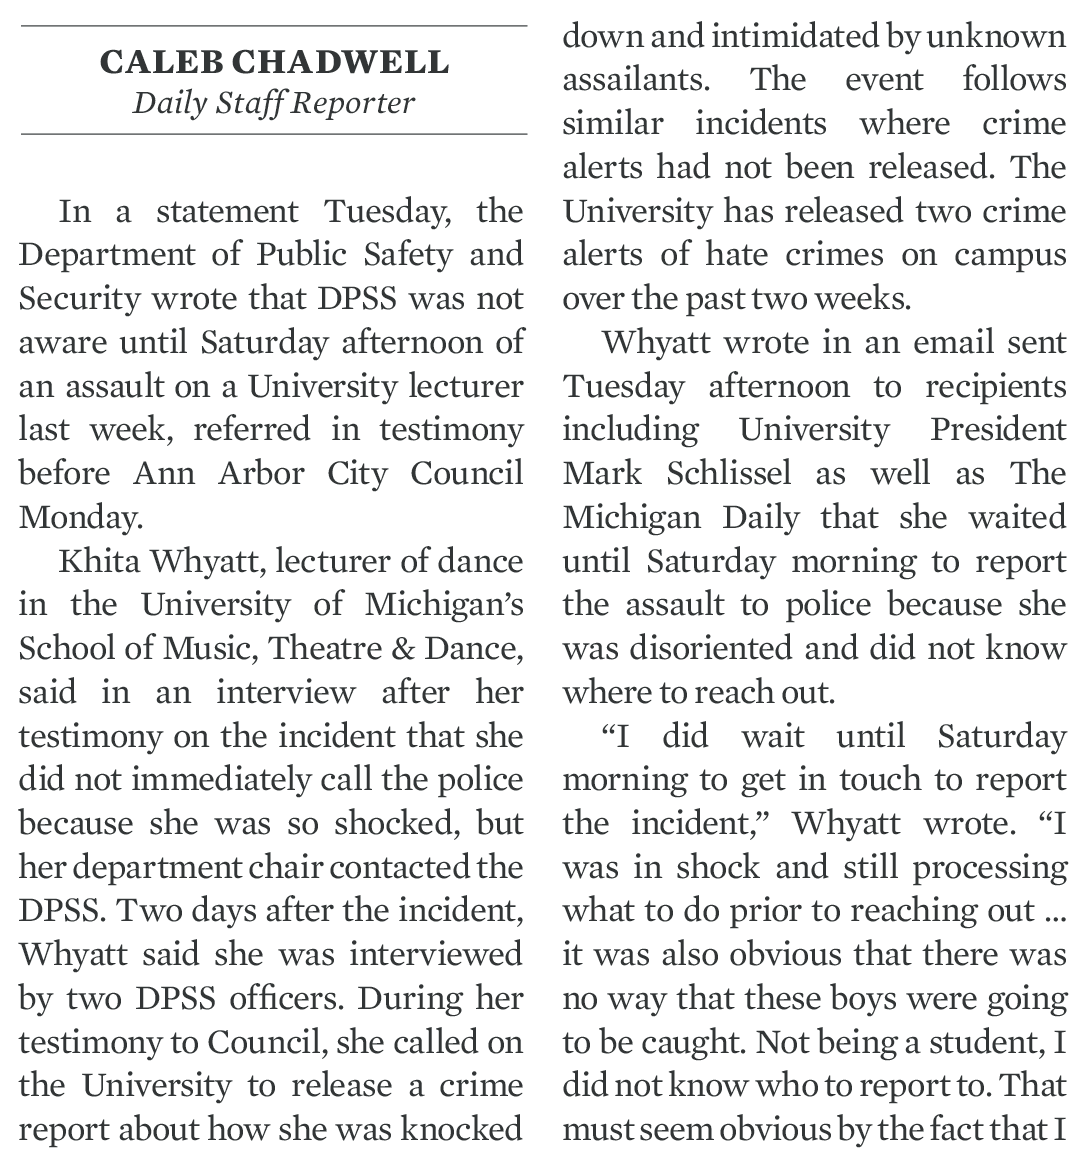

[[100, 50, 449, 74], [131, 88, 414, 120], [59, 196, 522, 229], [18, 239, 522, 272], [19, 283, 522, 316], [19, 327, 525, 360], [19, 371, 523, 404], [18, 414, 524, 447], [17, 458, 522, 491], [19, 502, 141, 535], [58, 546, 521, 579], [18, 589, 522, 622], [19, 633, 521, 665], [563, 21, 1066, 54], [564, 64, 1066, 91], [563, 108, 1066, 135], [564, 152, 1065, 179], [563, 196, 1065, 229], [563, 239, 1066, 272], [562, 283, 909, 316], [600, 327, 1066, 360], [562, 371, 1066, 404], [562, 414, 1066, 447], [563, 458, 1065, 485], [563, 502, 1065, 535], [562, 546, 1066, 579], [562, 589, 1064, 622], [562, 633, 1066, 660], [18, 677, 833, 704], [18, 721, 1066, 754], [18, 764, 1065, 797], [17, 808, 1065, 841], [18, 852, 1067, 885], [18, 895, 1065, 928], [17, 939, 1065, 972], [17, 983, 1067, 1016], [18, 1027, 1065, 1060], [18, 1070, 1065, 1103], [18, 1114, 1065, 1147]]


In [6]:
from PIL import Image
im=Image.open("images/news-text.png")
display(im)
# Lets now convert it to black and white and segment it up into lines with kraken
bounding_boxes=pageseg.segment(im.convert('1'))['boxes']
# And lets print those lines to the screen
print(bounding_boxes)

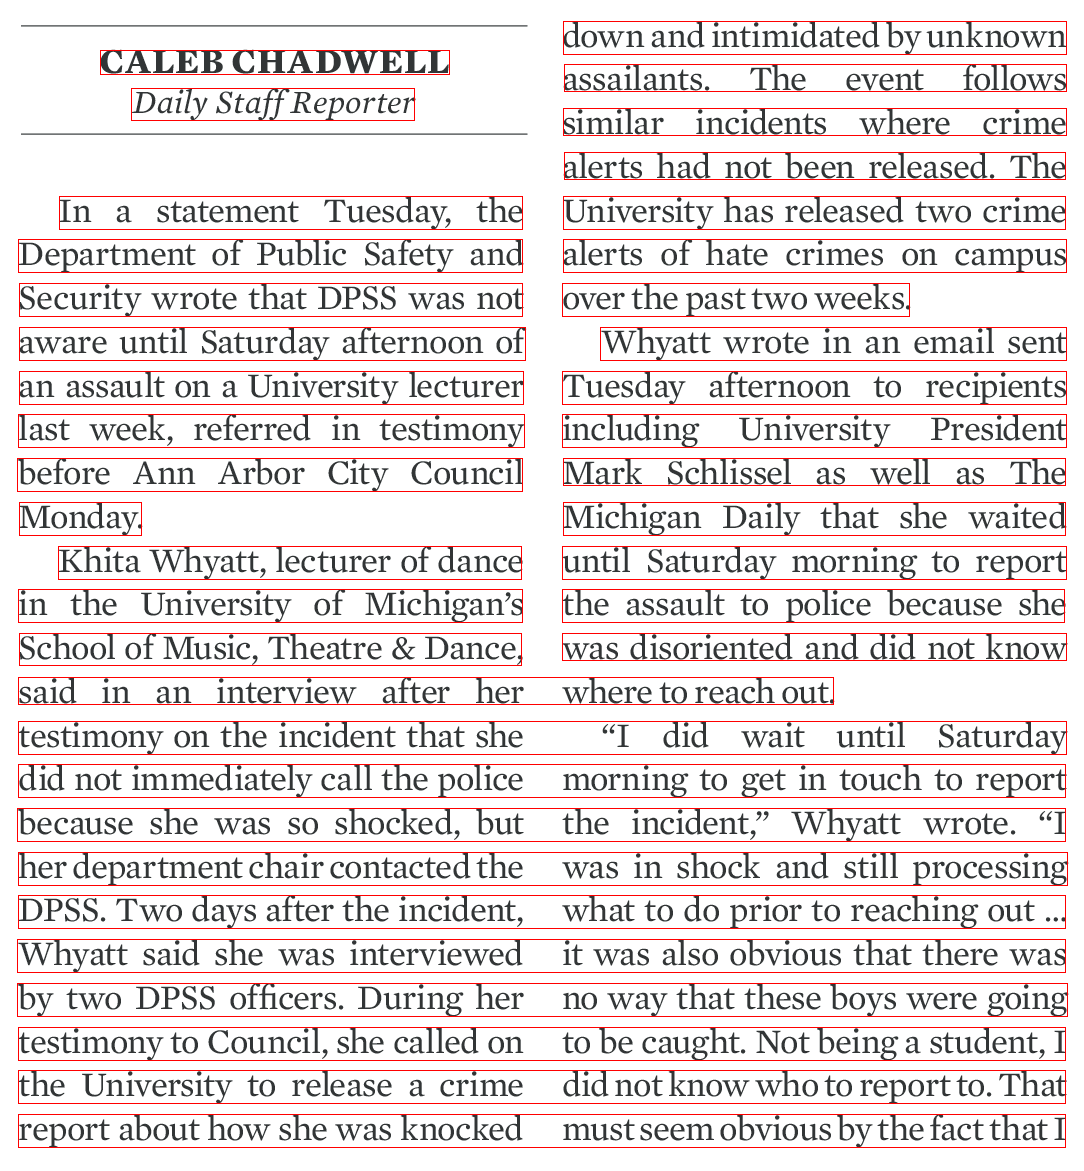

In [7]:
def show_boxes(img):
    '''Modifies the passed image to show a series of bounding boxes on an image as run by kraken
    
    :param img: A PIL.Image object
    :return img: The modified PIL.Image object
    '''
    # Lets bring in our ImageDraw object
    from PIL import ImageDraw
    # And grab a drawing object to annotate that image
    drawing_object=ImageDraw.Draw(img)
    # We can create a set of boxes using pageseg.segment
    bounding_boxes=pageseg.segment(img.convert('1'))['boxes']
    # Now lets go through the list of bounding boxes
    for box in bounding_boxes:
        # An just draw a nice rectangle
        drawing_object.rectangle(box, fill = None, outline ='red')
    # And to make it easy, lets return the image object
    return img

# To test this, lets use display
display(show_boxes(Image.open("images/news-text.png")))

In [9]:
char_width=25
# The height is harder, since it depends on the height of the text. I'm going to write a routine
# to calculate the average height of a line
def calculate_line_height(img):
    '''Calculates the average height of a line from a given image
    :param img: A PIL.Image object
    :return: The average line height in pixels
    '''
    # Lets get a list of bounding boxes for this image
    bounding_boxes=pageseg.segment(img.convert('1'))['boxes']
    # Each box is a tuple of (top, left, bottom, right) so the height is just top - bottom
    # So lets just calculate this over the set of all boxes
    height_accumulator=0
    for box in bounding_boxes:
        height_accumulator=height_accumulator+box[3]-box[1]
        # this is a bit tricky, remember that we start counting at the upper left corner in PIL!
    # now lets just return the average height
    # lets change it to the nearest full pixel by making it an integer
    return int(height_accumulator/len(bounding_boxes))

# And lets test this with the image with have been using
line_height=calculate_line_height(Image.open("images/news-text.png"))
print(line_height)

31


In [10]:
gap_box=(0,0,char_width,line_height*6)
gap_box

(0, 0, 25, 186)

In [11]:
def gap_check(img, location):
    '''Checks the img in a given (x,y) location to see if it fits the description
    of a gap_box
    :param img: A PIL.Image file
    :param location: A tuple (x,y) which is a pixel location in that image
    :return: True if that fits the definition of a gap_box, otherwise False
    '''
    
    for x in range(location[0], location[0]+gap_box[2]):
        # the height is similar, so lets iterate a y variable to gap_box[3]
        for y in range(location[1], location[1]+gap_box[3]):
            # we want to check if the pixel is white, but only if we are still within the image
            if x < img.width and y < img.height:
                # if the pixel is white we don't do anything, if it's black, we just want to
                # finish and return False
                if img.getpixel((x,y)) != 255:
                    return False
    # If we have managed to walk all through the gap_box without finding any non-white pixels
    # then we can return true -- this is a gap!
    return True

In [14]:
def draw_sep(img,location):
    '''Draws a line in img in the middle of the gap discovered at location. Note that
    this doesn't draw the line in location, but draws it at the middle of a gap_box
    starting at location.
    :param img: A PIL.Image file
    :param location: A tuple(x,y) which is a pixel location in the image
    '''
    # First lets bring in all of our drawing code
    from PIL import ImageDraw
    drawing_object=ImageDraw.Draw(img)
    # next, lets decide what the middle means in terms of coordinates in the image
    x1=location[0]+int(gap_box[2]/2)
    # and our x2 is just the same thing, since this is a one pixel vertical line
    x2=x1
    # our starting y coordinate is just the y coordinate which was passed in, the top of the box
    y1=location[1]
    # but we want our final y coordinate to be the bottom of the box
    y2=y1+gap_box[3]
    drawing_object.rectangle((x1,y1,x2,y2), fill = 'black', outline ='black')
    # and we don't have anything we need to return from this, because we modified the image

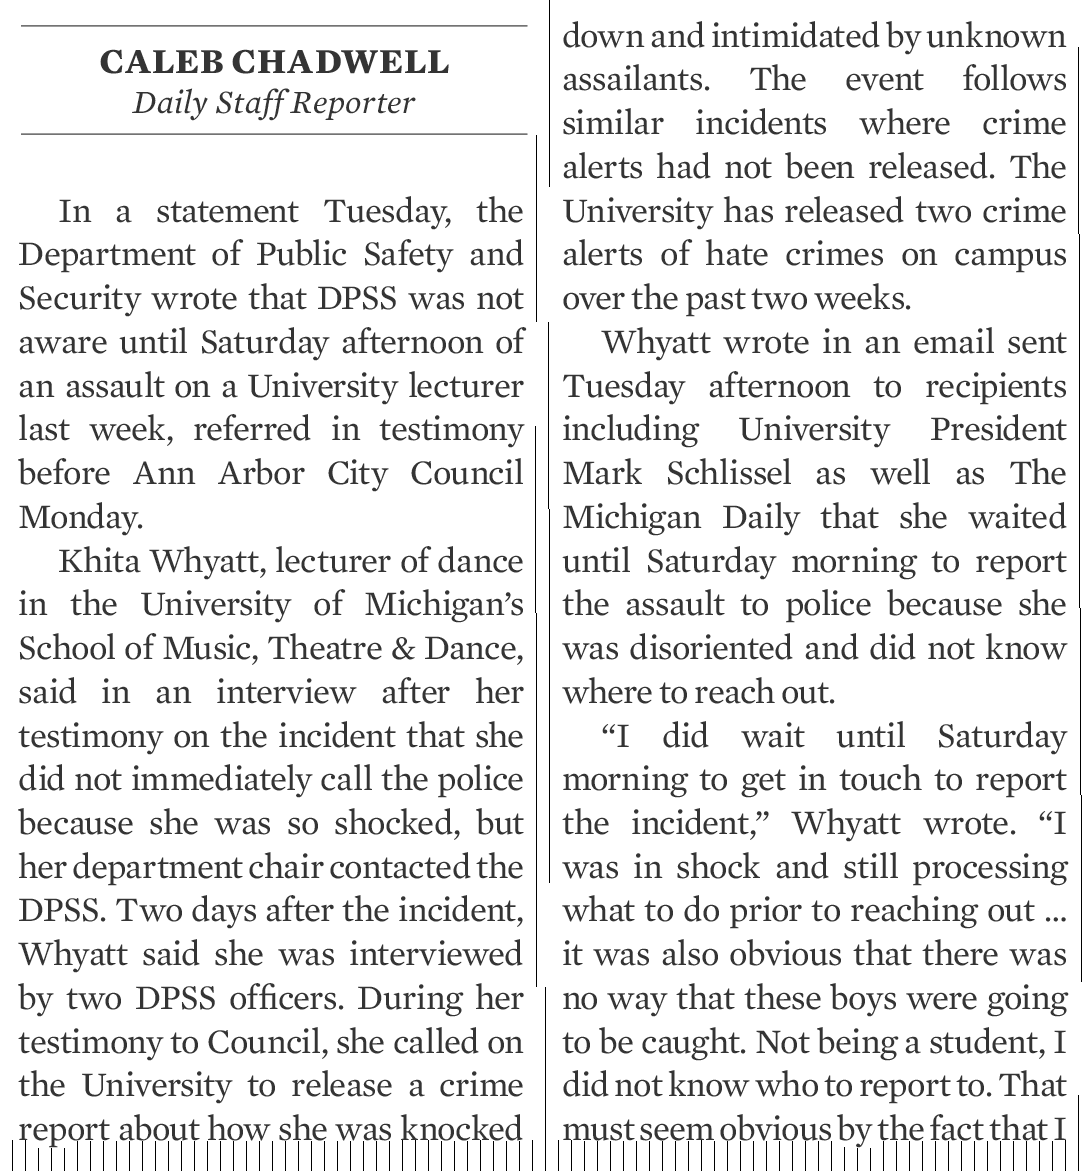

In [15]:
def process_image(img):
    '''Takes in an image of text and adds black vertical bars to break up columns
    :param img: A PIL.Image file
    :return: A modified PIL.Image file
    '''
    # we'll start with a familiar iteration process
    for x in range(img.width):
        for y in range(img.height):
            # check if there is a gap at this point
            if (gap_check(img, (x,y))):
                # then update image to one which has a separator drawn on it
                draw_sep(img, (x,y))
    # and for good measure we'll return the image we modified
    return img

# Lets read in our test image and convert it through binarization
i=Image.open("images/news-text.png").convert("L")
i=process_image(i)
display(i)

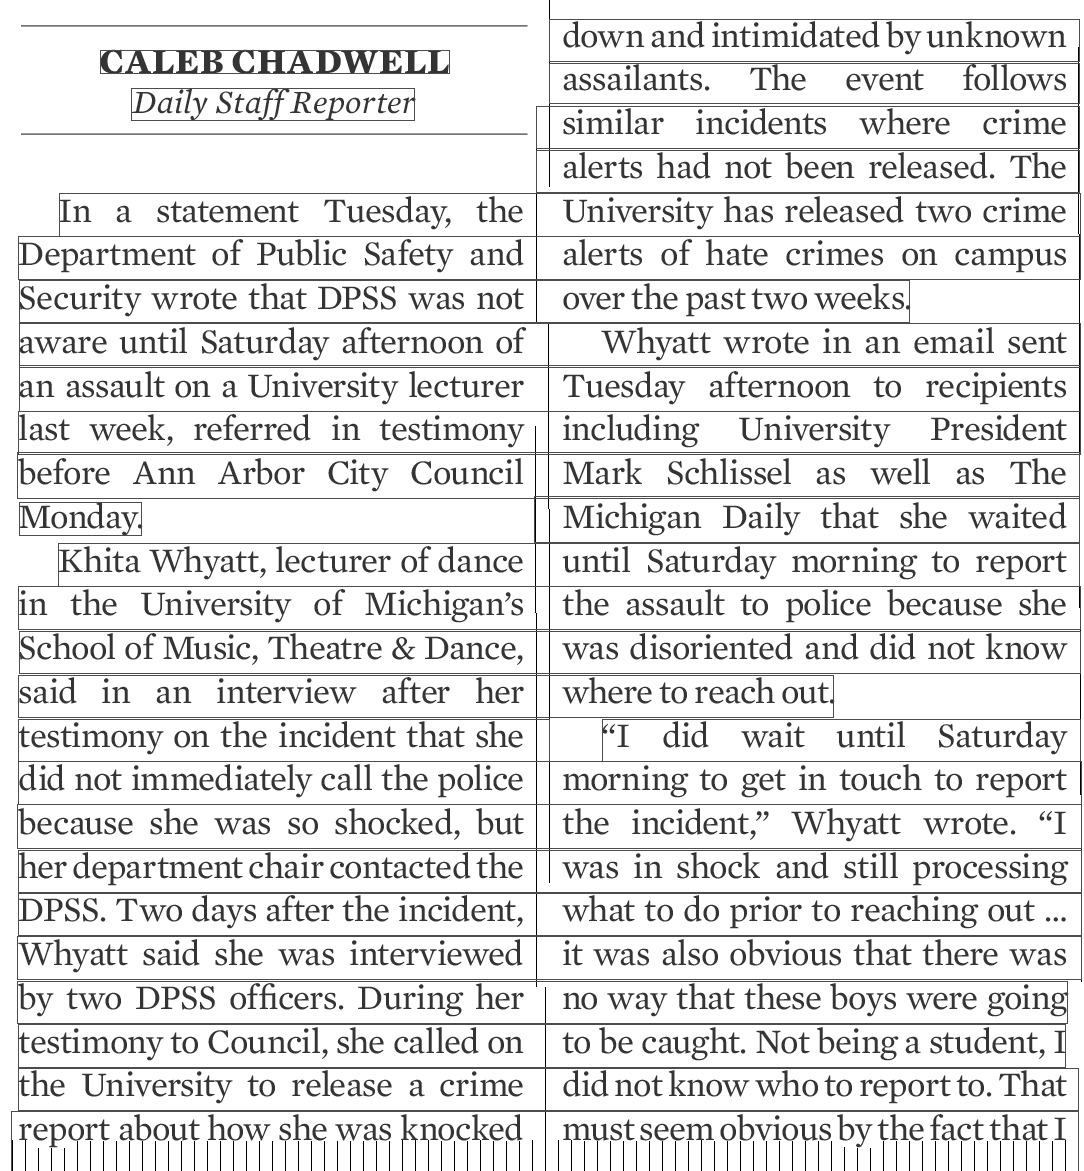

In [16]:
display(show_boxes(i))